In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

import seaborn as sns
from scipy import stats
!pip install statsmodels
import statsmodels.api as sm
import time                                                     

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
app_train_red = pd.read_csv("app_train_red.csv")
# app_test_red = pd.read_csv("app_test_red.csv")

In [3]:
# app_train_red.drop("0")
app_train_red.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,0,0,0,0,0,0,0,0,0,0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,0,0,0,0,0,0,0,0,0,0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,0,0,0,0,0,0,0,0,0,0
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,0,0,0,0,0,0,0,0,0,0


## Current Applications EDA

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='DAYS_EMPLOYED'>

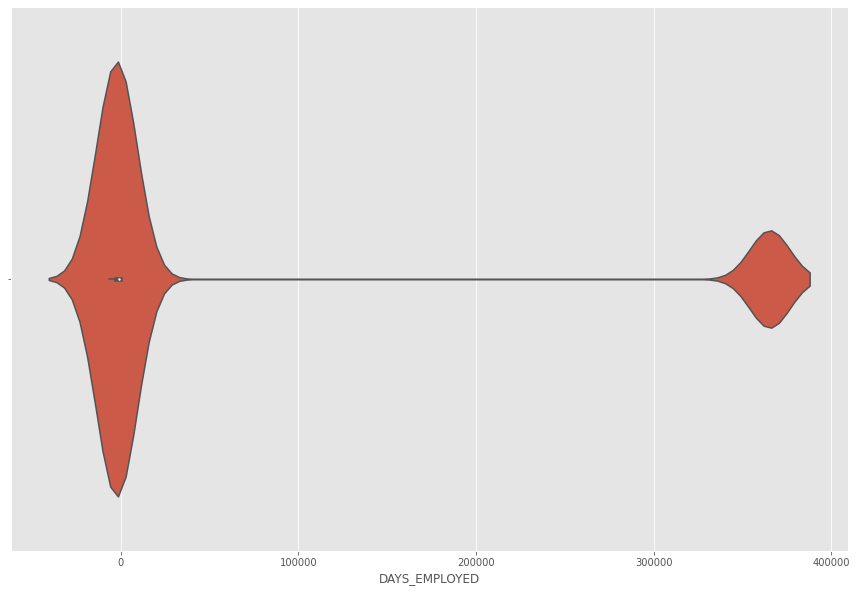

In [4]:
sns.violinplot(app_train_red.DAYS_EMPLOYED)

A violin plot of the number of days the borrower has been employed brings up something highly suspicious. The days employed are counted with respect to the current application, so the majority of them are "negative", as is expected. Oddly, there is a giant spike at about 350000 days positive. Since days are counted as days before submition of the application, this makes the positve 350000 spike highly suspect, not to mention it eqauted to  about 800+ years. 

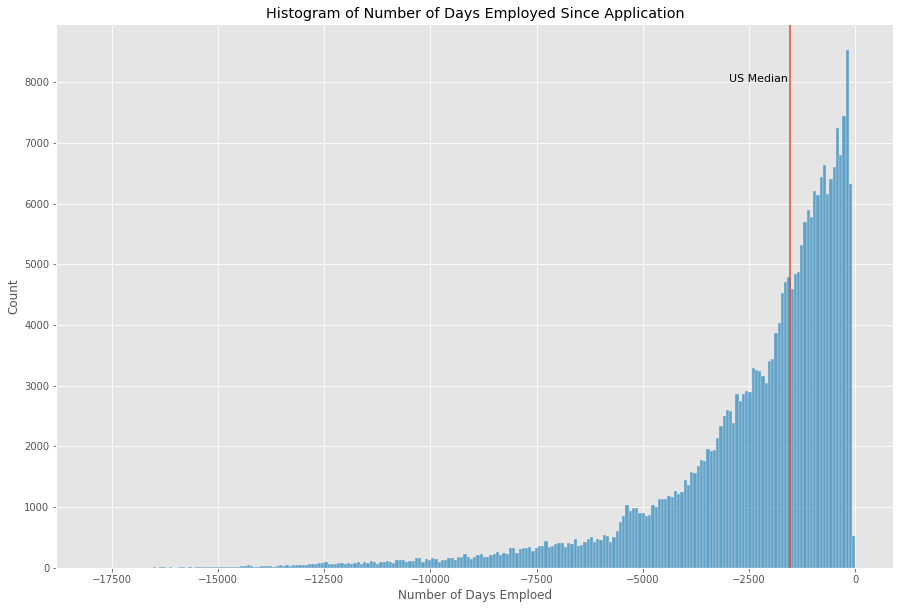

In [5]:
fig, ax1 = plt.subplots()
sns.histplot(app_train_red.DAYS_EMPLOYED[app_train_red.DAYS_EMPLOYED < 10], ax = ax1)
plt.axvline(- 4.2 * 365, 0, 8200)
ax1.set_title("Histogram of Number of Days Employed Since Application")
ax1.set_xlabel("Number of Days Emploed")
ax1.set_ylabel("Count")
ax1.text(- 4.2 * 365 - 1450, 8000, "US Median", fontsize = 11)
plt.show()

Excluding the outliers, the rest of the data exhibits normal behavior and appears to be lognormally distributed. This seems reasonable since according to the Bereau of Labor and Statistics, the median number of years workers tend to stay with the same employer is about 4.2 years in 2020 (assuming this is excluding the rise of unemployment and job losses due to the pandemic). Since Home Credit is primarily based in Asia, I expect the distribution to be similar to the US's but skewed to the lower end, meaning less people being tenured longer with the same employer. Comparing the US median to the dataset shows this to be true. The 4.2 year mark has 56.7% of the applicants being employed less than 4.2 years.

The more interesting question is what is up with the people having a positive employment time, ie the weird ones. 

In [6]:
len(app_train_red.DAYS_EMPLOYED[app_train_red.DAYS_EMPLOYED < - 4.2 * 365]) / len(app_train_red) * 100

43.30154043269997

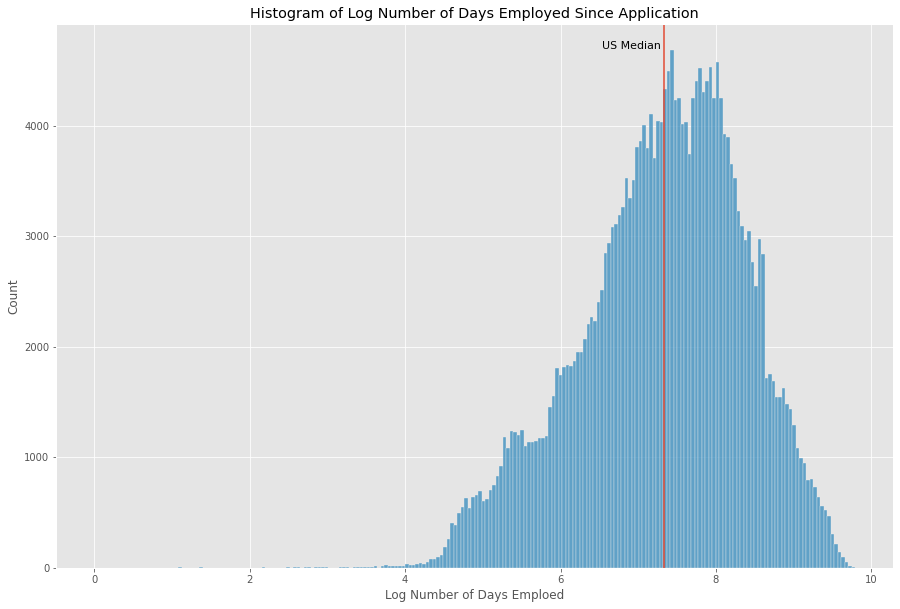

In [7]:
fig, ax1 = plt.subplots()
sns.histplot(np.log(-1 * app_train_red.DAYS_EMPLOYED[app_train_red.DAYS_EMPLOYED < 0]), ax = ax1)
plt.axvline(np.log(4.2 * 365), 0, 8200)
ax1.set_title("Histogram of Log Number of Days Employed Since Application")
ax1.set_xlabel("Log Number of Days Emploed")
ax1.set_ylabel("Count")
ax1.text(np.log(4.2 * 365) - 0.8, 4700, "US Median", fontsize = 11)
plt.show()

#### The Weird Ones

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Probability'>

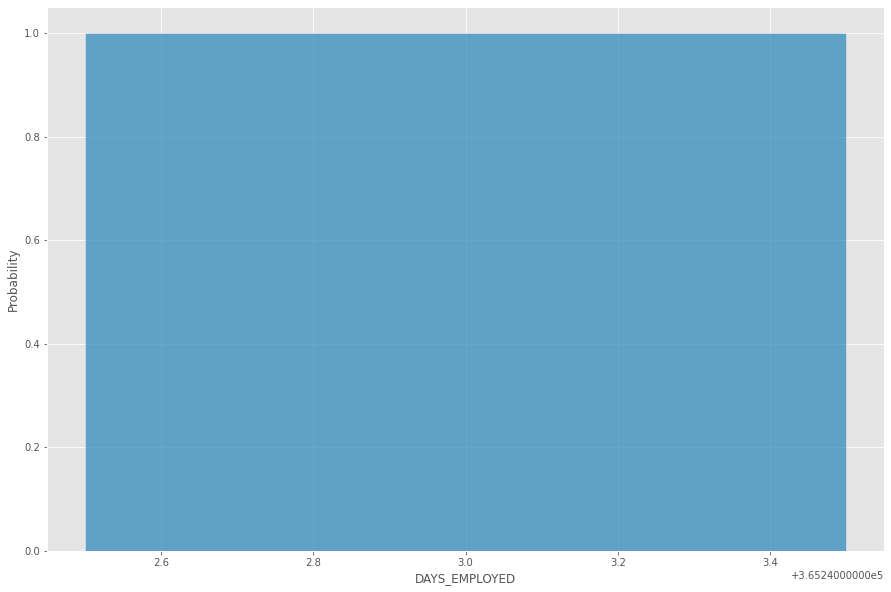

In [8]:
weird_ones = app_train_red[app_train_red.DAYS_EMPLOYED > 0]
sns.histplot(x = weird_ones.DAYS_EMPLOYED, stat = "probability")

The weird ones all have a specific values assigned to them, as if it was done on purpose. They are all concentrated on the value of 365240 days, which translates to 1000 years, which is a long time to be employed(?). Perhaps this is less weird and more compensating for people who are unemployed or something to that extent which was not included in the dataset description instead of leaving the value as missing. 

<AxesSubplot:xlabel='TARGET', ylabel='count'>

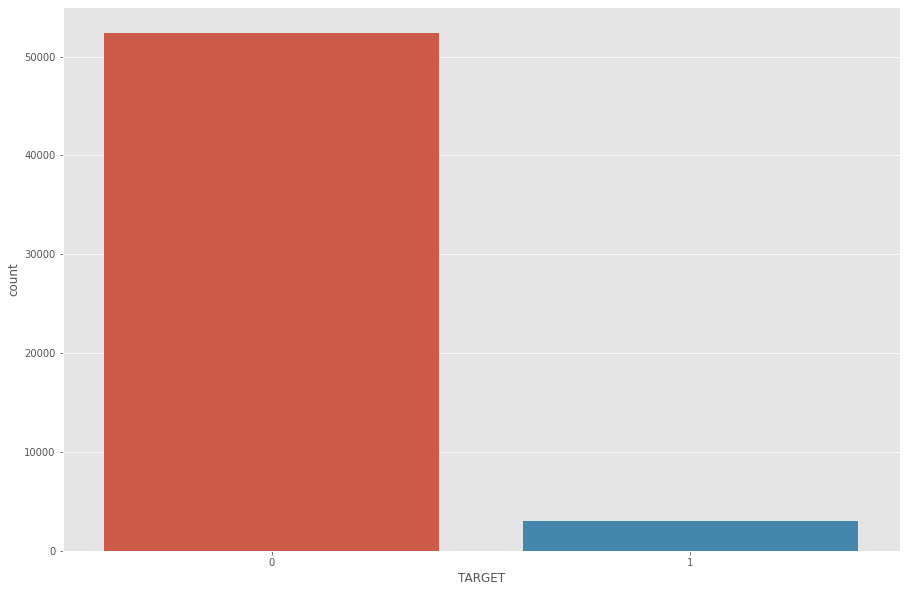

In [9]:
sns.countplot(x = weird_ones.TARGET)

In [10]:
df = pd.merge(app_train_red, weird_ones, on = "SK_ID_CURR", how = "left", indicator = "Weird")
df.Weird = df.Weird == "both"

<AxesSubplot:xlabel='Weird', ylabel='count'>

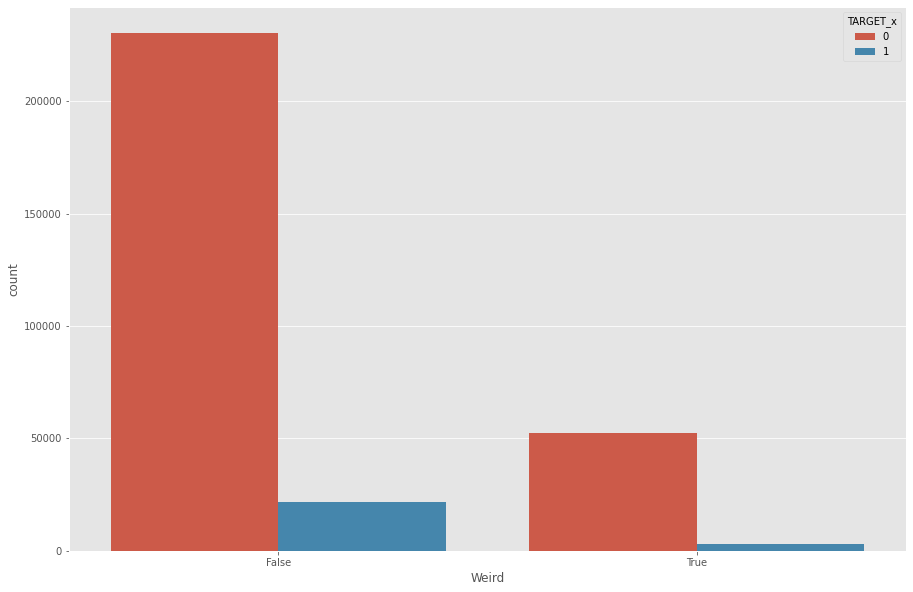

In [11]:
sns.countplot(x = df.Weird, hue = df.TARGET_x)
# trying to find the percentage of target variable relative to the amount of people in weird group vs non weird

   Weird  TARGET_x   total   percent
0  False         0  230302  0.913400
1  False         1   21835  0.086600
2   True         0   52384  0.946004
3   True         1    2990  0.053996


<AxesSubplot:xlabel='Weird', ylabel='percent'>

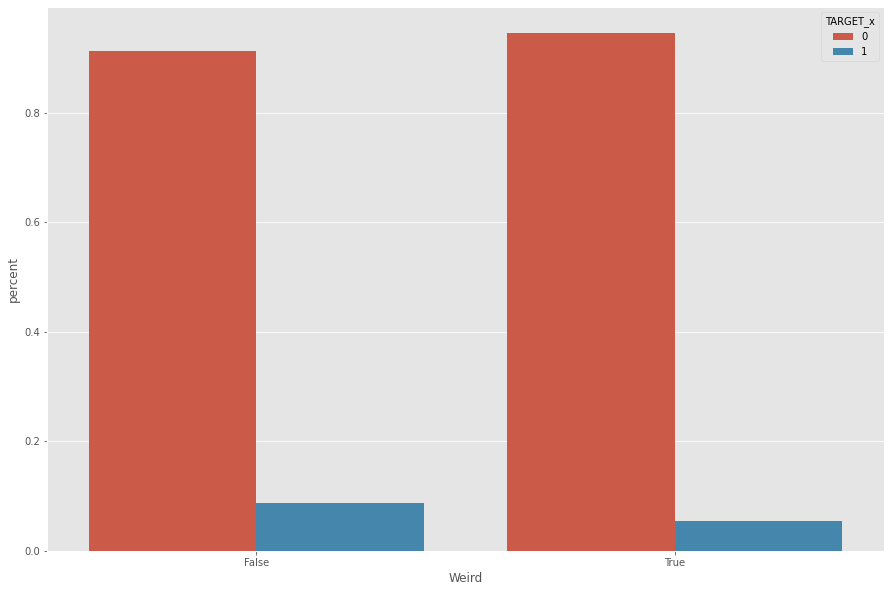

In [12]:
df1 = df.groupby(["Weird", "TARGET_x"]).TARGET_x.agg(total = "count").reset_index()
df2 = df1.groupby(by = "Weird").apply(lambda x: x / x.sum())
df1["percent"] = df2.total
print(df1)
sns.barplot(x = "Weird", y = "percent", data = df1, hue = "TARGET_x")

In [13]:
contingency_table = pd.crosstab(df.Weird, df.TARGET_x)
contingency_table

TARGET_x,0,1
Weird,,
False,230302,21835
True,52384,2990


In [14]:
def cramers_v(cross_table):
    chi, p, dofs, exp_cnts = stats.chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi = chi / n
    k = cross_table.shape[0]
    r = cross_table.shape[1]
    v = np.sqrt((chi / n) / (min(k-1, r-1)))

    phi_bar = max(0, phi - (k - 1)*(r - 1) / (n - 1))
    k_bar = k - (k-1)**2 / (n-1)
    r_bar = r - (r-1)**2 / (n-1)
    v_corrected = np.sqrt(phi_bar / min(k_bar - 1, r_bar - 1))
    return v, v_corrected, p, chi


def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    mux = np.mean(x)
    muy = np.mean(y)
    sdx = np.std(x, ddof = 1)
    sdy = np.std(y, ddof = 1)
    sd_pooled = np.sqrt( ((nx - 1)*sdx**2 + (ny - 1)*sdy**2) / (nx + ny - 2) )
    return (mux - muy) / sd_pooled

In [15]:
cram_v, cram_v_corrected, p, chi = cramers_v(contingency_table)
print("The Chi-Squared statistic is %f and \n the corresponding p-value is %f. \n Moreover, the Cramer's V statistic is %f \n and the bias corrected Cramer's V statistic is %f" %(chi, p, cram_v, cram_v_corrected))

The Chi-Squared statistic is 649.888509 and 
 the corresponding p-value is 0.000000. 
 Moreover, the Cramer's V statistic is 0.045972 
 and the bias corrected Cramer's V statistic is 0.045936


<AxesSubplot:xlabel='Weird', ylabel='AMT_INCOME_TOTAL_x'>

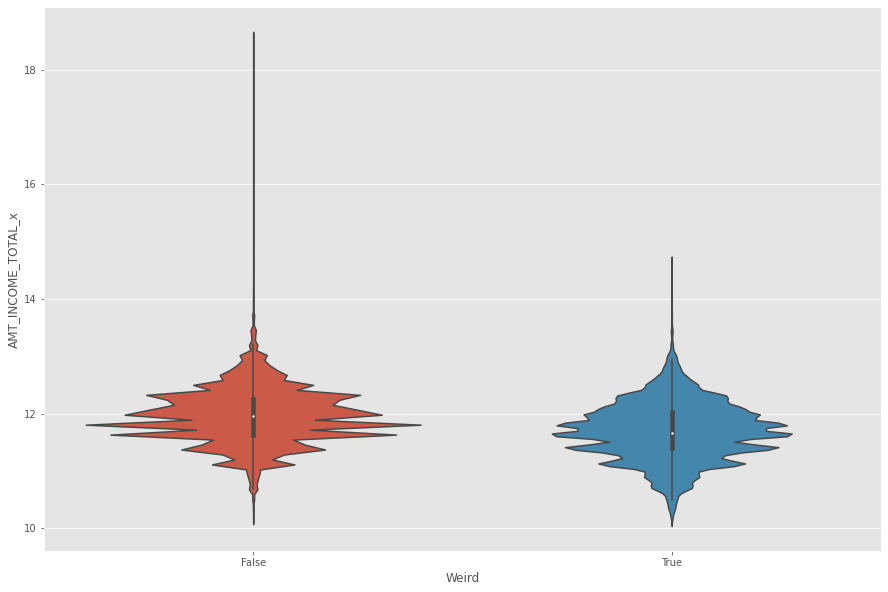

In [16]:
sns.violinplot(x = df.Weird , y =  np.log(df.AMT_INCOME_TOTAL_x))

In [17]:
stats.ttest_ind(np.log(df.AMT_INCOME_TOTAL_x[df.Weird == True]), np.log(df.AMT_INCOME_TOTAL_x[df.Weird == False]), equal_var = False)

Ttest_indResult(statistic=-111.80458773557551, pvalue=0.0)

In [18]:
d = cohens_d(np.log(df.AMT_INCOME_TOTAL_x[df.Weird == True]), np.log(df.AMT_INCOME_TOTAL_x[df.Weird == False]))
np.exp(d)


0.5803273745958207

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='Density'>

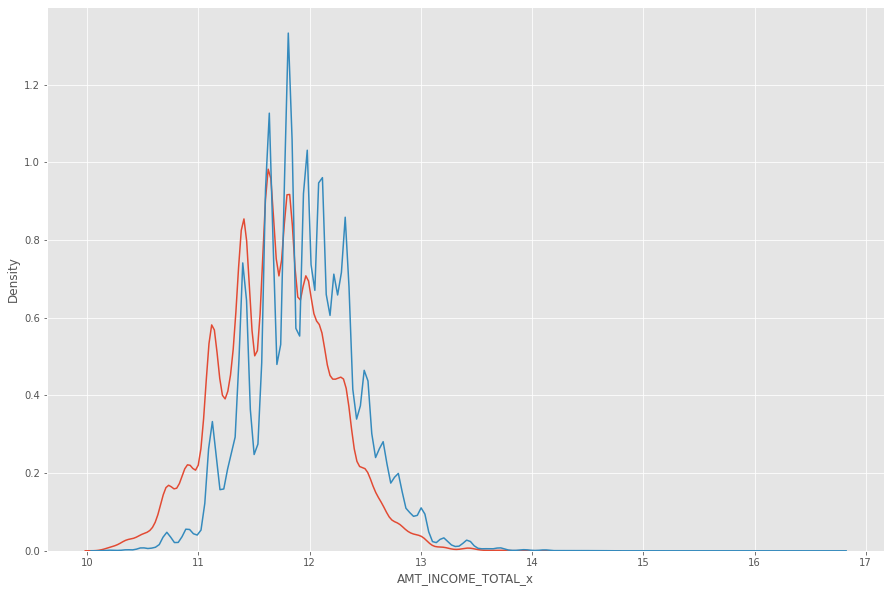

In [19]:
condition = df.AMT_INCOME_TOTAL_x < 50000000

sns.kdeplot(np.log(df.AMT_INCOME_TOTAL_x[(df.Weird == True) & condition]))
sns.kdeplot(np.log(df.AMT_INCOME_TOTAL_x[(df.Weird == False) & condition]))

In [20]:
weird_ones.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,...,0,0,0,0,0,0,0,0,0,0
11,11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,...,0,0,0,0,0,0,0,0,0,0
23,23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,...,0,0,0,0,0,0,0,0,0,0
38,38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,...,0,0,0,0,0,0,0,0,0,0
43,43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='CODE_GENDER_x', ylabel='percent'>

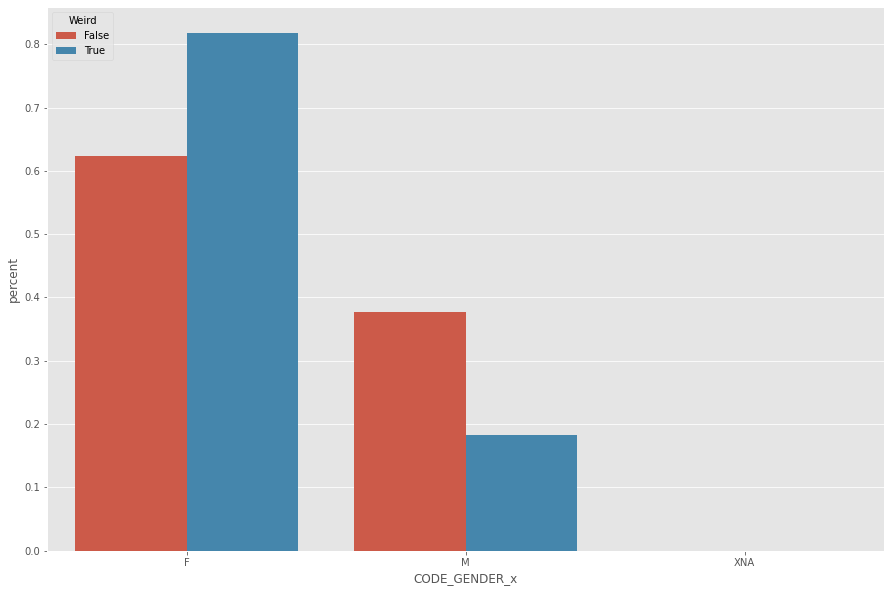

In [21]:
weird_gender = df.groupby(["Weird", "CODE_GENDER_x"]).CODE_GENDER_x.agg(total = "count").reset_index()
weird_gender["percent"] = weird_gender.groupby("Weird").total.apply(lambda x: x / x.sum())

sns.barplot(data = weird_gender, x = "CODE_GENDER_x", y = "percent", hue = "Weird")

In [22]:
weird_ones.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,...,0,0,0,0,0,0,0,0,0,0
11,11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,...,0,0,0,0,0,0,0,0,0,0
23,23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,...,0,0,0,0,0,0,0,0,0,0
38,38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,...,0,0,0,0,0,0,0,0,0,0
43,43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 864x720 with 0 Axes>

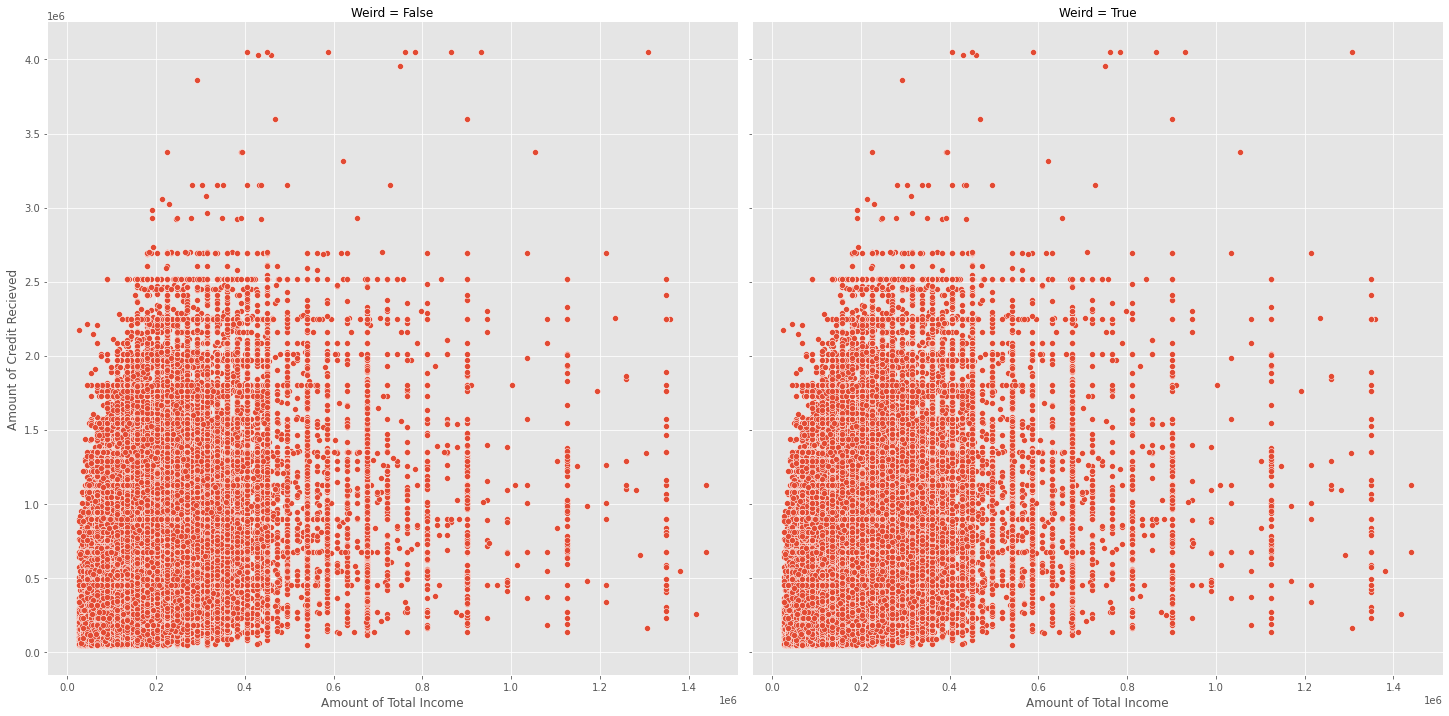

In [23]:
condition = df.AMT_INCOME_TOTAL_x < 1500000

plt.figure(figsize = (12, 10))
g = sns.FacetGrid(df, col = "Weird", height = 10)
g.map_dataframe(sns.scatterplot, x = df.AMT_INCOME_TOTAL_x[condition], y = df.AMT_CREDIT_x[condition])
g.set_axis_labels("Amount of Total Income", "Amount of Credit Recieved")

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='AMT_CREDIT_x'>

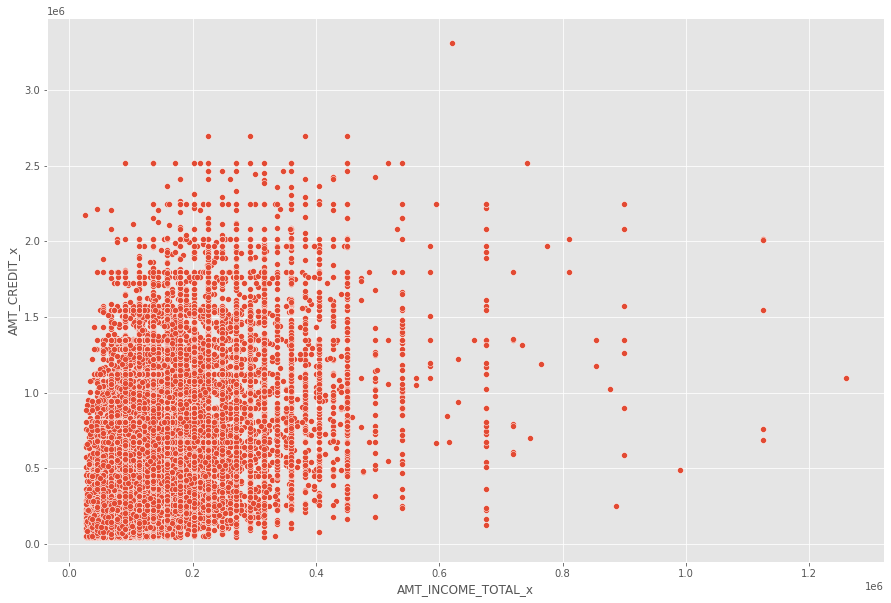

In [24]:
condition = df.AMT_INCOME_TOTAL_x < 1500000
sns.scatterplot(x = df.AMT_INCOME_TOTAL_x[condition & df.Weird == True], y = df.AMT_CREDIT_x[condition & df.Weird == True])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='AMT_CREDIT_x'>

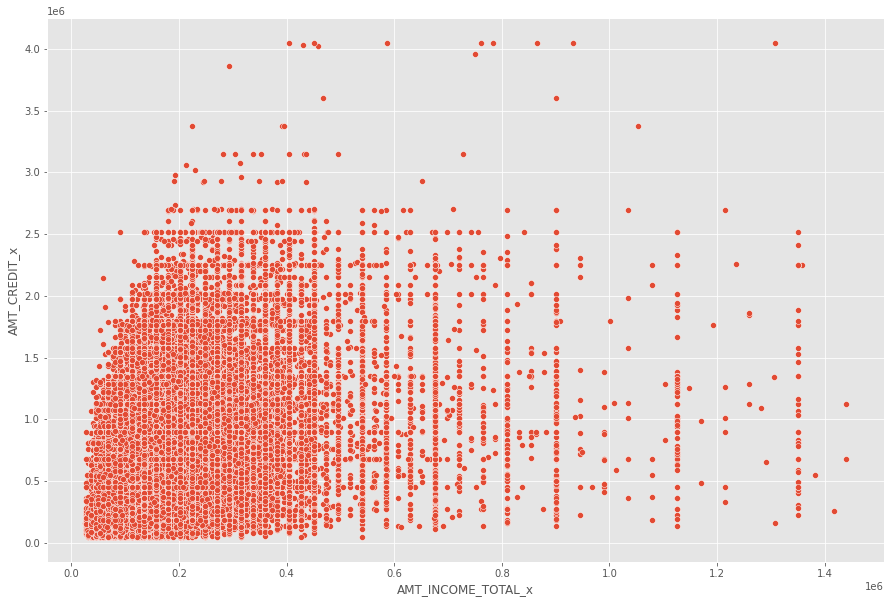

In [25]:
condition = df.AMT_INCOME_TOTAL_x < 1500000
sns.scatterplot(x = df.AMT_INCOME_TOTAL_x[condition & (df.Weird == False)], y = df.AMT_CREDIT_x[condition & (df.Weird == False)])

<AxesSubplot:xlabel='Weird', ylabel='percent'>

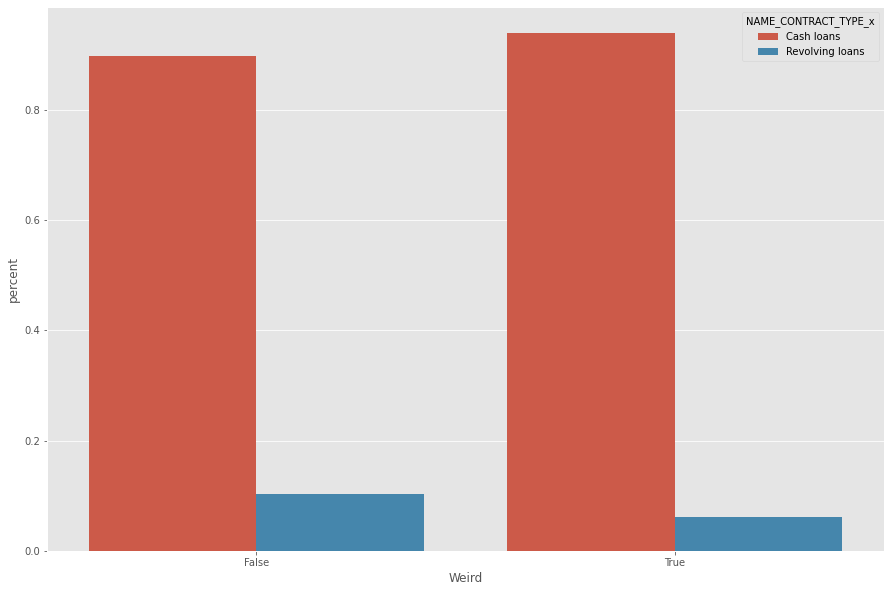

In [26]:
weird_contracts = df.groupby(["Weird", "NAME_CONTRACT_TYPE_x"]).NAME_CONTRACT_TYPE_x.agg(total = "count").reset_index()
weird_contracts['percent'] = weird_contracts.groupby(["Weird"]).total.apply(lambda x: x / x.sum())
sns.barplot(data = weird_contracts, x = "Weird", y = "percent" ,hue = "NAME_CONTRACT_TYPE_x")

In [27]:
weird_ones.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,...,0,0,0,0,0,0,0,0,0,0
11,11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,...,0,0,0,0,0,0,0,0,0,0
23,23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,...,0,0,0,0,0,0,0,0,0,0
38,38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,...,0,0,0,0,0,0,0,0,0,0
43,43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Marital Status Distribution of People in the Weird Category')

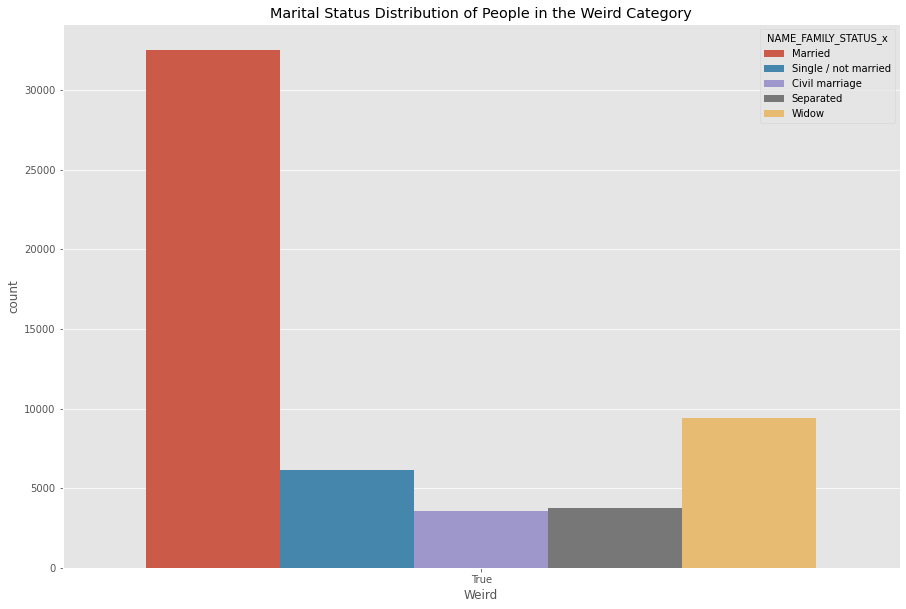

In [28]:
condition = df.Weird == True
sns.countplot(x = df.Weird[condition], hue = df.NAME_FAMILY_STATUS_x[condition])
plt.title("Marital Status Distribution of People in the Weird Category")

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


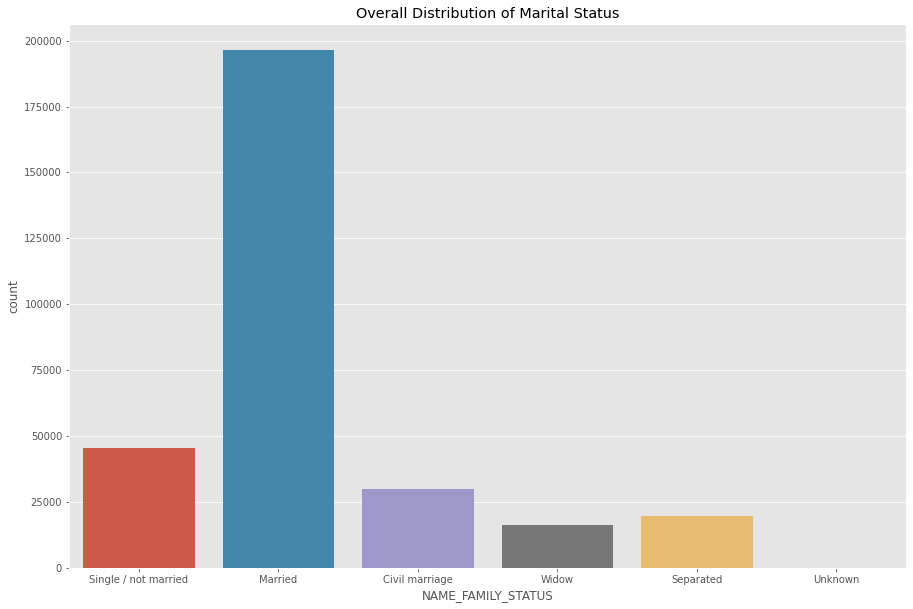

In [29]:
sns.countplot(app_train_red.NAME_FAMILY_STATUS)
plt.title("Overall Distribution of Marital Status")
plt.show()

<AxesSubplot:xlabel='NAME_FAMILY_STATUS_x', ylabel='percent'>

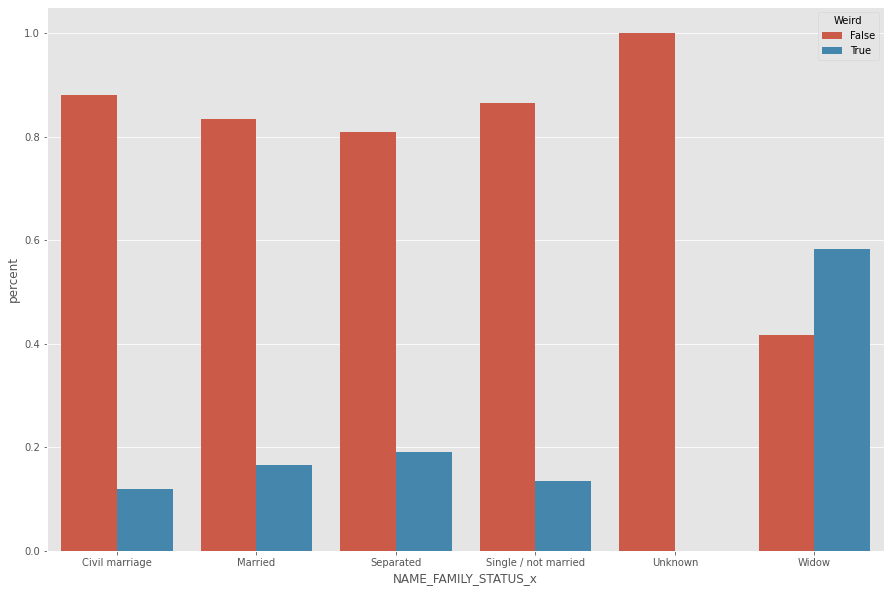

In [30]:
weird_married = df.groupby(["NAME_FAMILY_STATUS_x", "Weird"]).NAME_FAMILY_STATUS_x.agg(total = "count").reset_index()
weird_married["percent"] = weird_married.groupby("NAME_FAMILY_STATUS_x").total.apply(lambda x: x/x.sum())
weird_married

sns.barplot(data = weird_married, x = "NAME_FAMILY_STATUS_x", y = "percent", hue = "Weird")

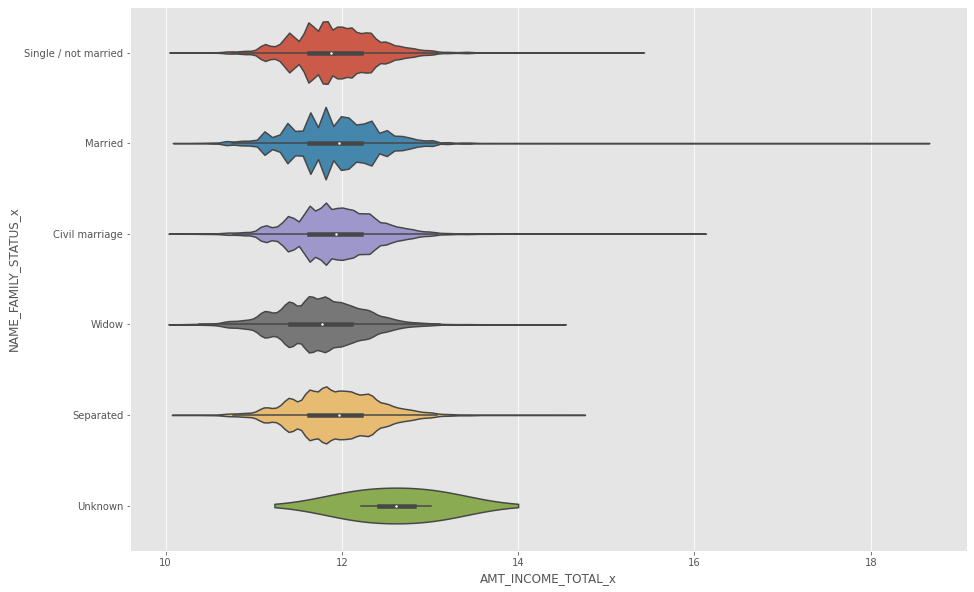

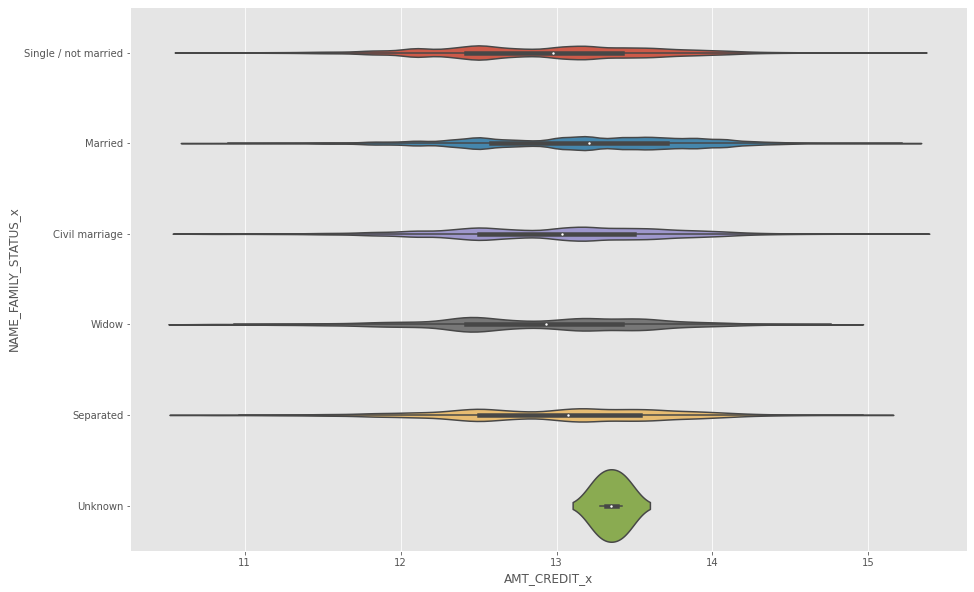

In [31]:
sns.violinplot(x = np.log(df.AMT_INCOME_TOTAL_x), y = df.NAME_FAMILY_STATUS_x)
plt.show()
sns.violinplot(x = np.log(df.AMT_CREDIT_x), y = df.NAME_FAMILY_STATUS_x)
plt.show()

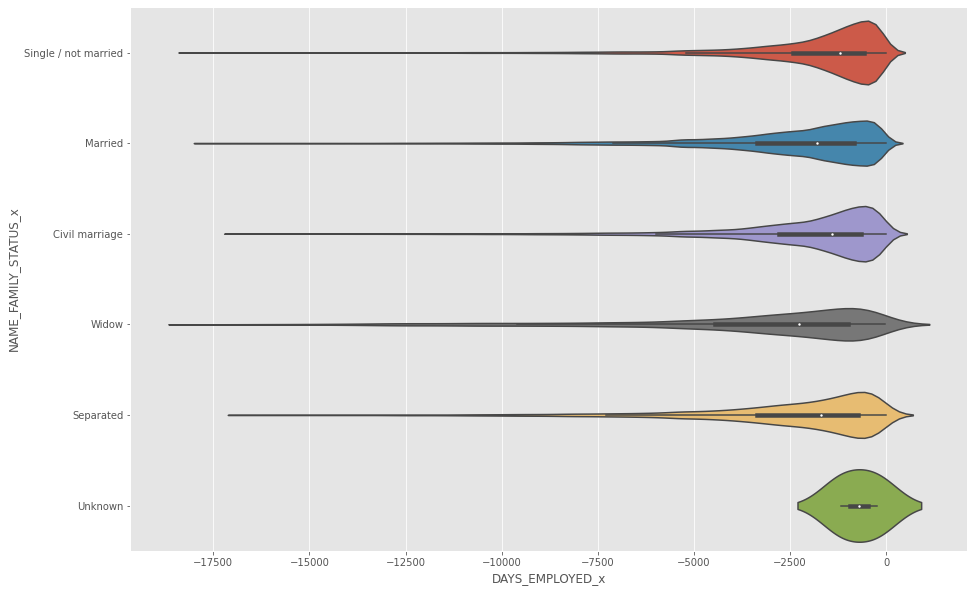

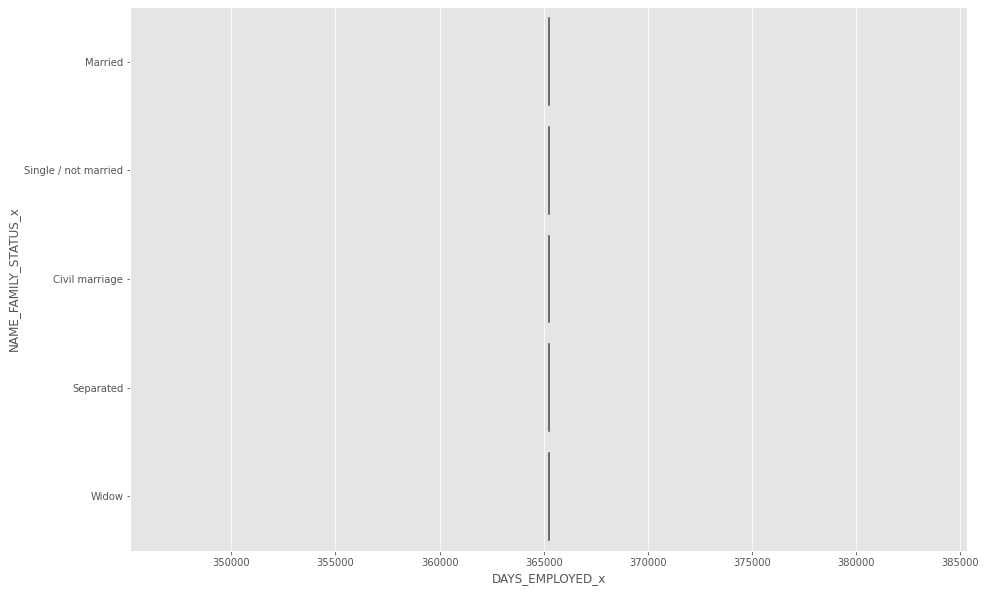

In [32]:
condition = df.DAYS_EMPLOYED_x < 0
sns.violinplot(y = df.NAME_FAMILY_STATUS_x[condition], x = df.DAYS_EMPLOYED_x[condition])
plt.show()

condition = df.DAYS_EMPLOYED_x > 0
sns.violinplot(y = df.NAME_FAMILY_STATUS_x[condition], x = df.DAYS_EMPLOYED_x[condition])
plt.show()

   Weird    NAME_INCOME_TYPE_x   total   Percent
0  False           Businessman      10  0.000040
1  False  Commercial associate   71617  0.284040
2  False       Maternity leave       5  0.000020
3  False             Pensioner      10  0.000040
4  False         State servant   21703  0.086076
5  False               Student      18  0.000071
6  False               Working  158774  0.629713
7   True             Pensioner   55352  0.999603
8   True            Unemployed      22  0.000397


<AxesSubplot:xlabel='NAME_INCOME_TYPE_x', ylabel='Percent'>

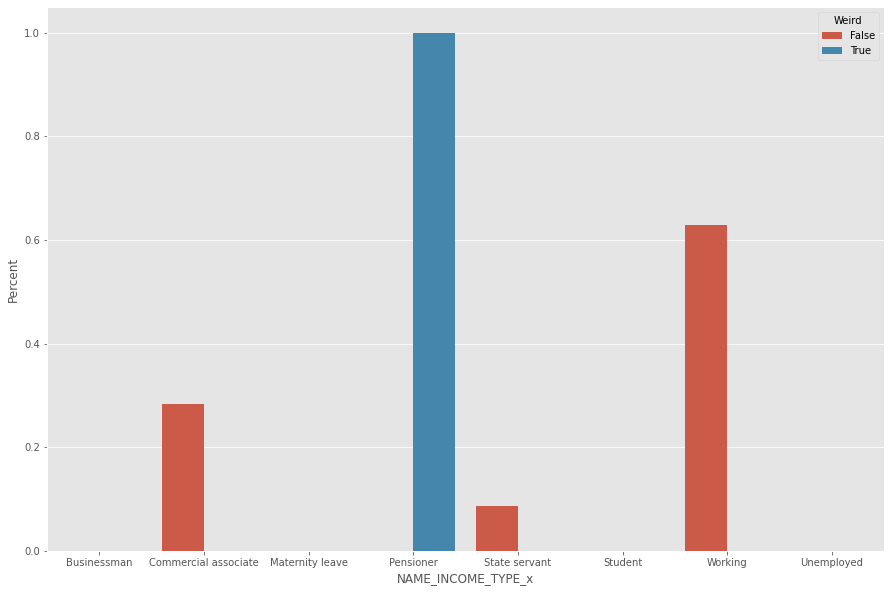

In [42]:
income_type = df.groupby(["Weird", "NAME_INCOME_TYPE_x"]).NAME_INCOME_TYPE_x.agg(total = "count").reset_index()
income_type["Percent"] = income_type.groupby("Weird").total.apply(lambda x: x/x.sum())
print(income_type)

sns.barplot(x = income_type.NAME_INCOME_TYPE_x, y = income_type.Percent, hue = income_type.Weird)

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity leave         0.000016
Name: NAME_INCOME_TYPE, dtype: float64


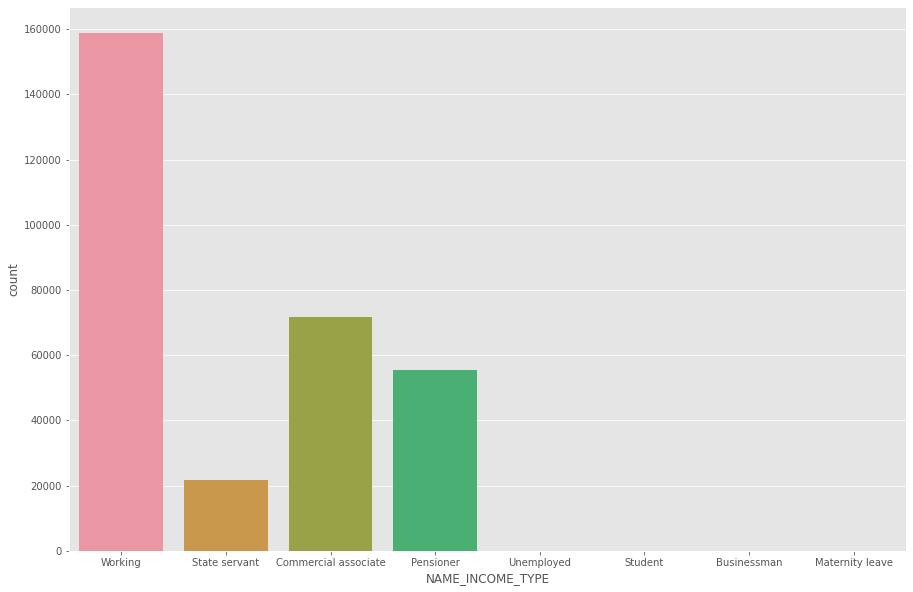

In [46]:
sns.countplot(app_train_red.NAME_INCOME_TYPE)
print(app_train_red.NAME_INCOME_TYPE.value_counts() / len(app_train_red))

In [43]:
len(weird_ones) / len(app_train_red)

0.18007160719453938

#### Weird Ones Summary
_Note: The days of employment variable is meant to track how long each borrower has been employed in their current occupation and is measured as the number of days prior to the application date, thus a majority of the values are 0 or a negative number. The borrowers denoted as weird have a positive value of number of days employed prior to the application, which does not make sense._

My findings of the subset of people having an odd range of employment, dubbed the weird ones, includes:
- a disproportionate amount of people in the subset are women
- they typically earn less than people who are not in the "Weird" category
- Most of the people are married, but that stems from the fact that the majority of borrowers in the dataset are married.
    - interestingly, a majority of the widows from the entire dataset tend to fall in the weird category.
    
- **Solution:** After some further exploration, the most likely answer as to why they have an odd amount of number of days employed is found under the variable describing their type of income. The vast majority of borrowers (> 99%) in the weird category are pensioners, meaning they are retired, which also goes on to explain why a relatively large proportion of them are widowers. It also makes sense since they are not currently employed and thus have to input some value. Now to solve this problem for model building.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9263f292-ea73-48e7-8892-f3d3ed1db03c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>